In [1]:
import sys
sys.path.insert(0, "../../..")
from paths import FIG_DIR

import numpy as np
import pandas as pd
import scipy.sparse as sp
import dynamo as dyn
from scipy.stats import spearmanr

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from graphvelo.plot import gene_trend
from graphvelo.graph_velocity import GraphVelo

/opt/anaconda3/envs/gv-reprod/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata= dyn.read('adata_gv.h5ad')
adata

AnnData object with n_obs × n_vars = 9815 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'mack_score'
    uns: 'celltype_colors', 'gv_params', 'log1p', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'gv_pca', 'gv_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 'f

In [3]:
color_map = {
    'Blood progenitors 1': '#f9decf',
    'Blood progenitors 2': '#c9a997',
    'Erythroid1': '#c72228', 
    'Erythroid2': '#f79083', 
    'Erythroid3': '#ef4e22'
}

In [4]:
adata_dyn = adata.copy()
dyn.tl.scv_dyn_convertor(adata_dyn)

|-----> Dynamo and scvelo have different preprocessing procedures and velocity estimation methods. The conversion of adata may not be optimal for every use case, requiring potential manual adjustments.
|-----> Start converting Scvelo adata into Dynamo adata...
|-----> Scvelo data wil be converted into Dynamo adata with the conventional assumption and thestochastic model. If this is not what you want, please change them manually.


AnnData object with n_obs × n_vars = 9815 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'mack_score', 'use_for_pca'
    uns: 'celltype_colors', 'gv_params', 'log1p', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'dynamics', 'pp', 'vel_params_names'
    obsm: 'X_pca', 'X_umap', 'gv_pca', 'gv_umap', 'velocity_umap'
    varm: 'PCs', 'loss', 'vel_params'
    layers: 'fit_t', 'fit_tau', 'fit_tau_', 'velocity_gv', 'X_spliced', 'X_

In [5]:
adata_dyn.layers['M_s'] = sp.csr_matrix(adata_dyn.layers['M_s'])
adata_dyn.layers['velocity_S'] = sp.csr_matrix(adata_dyn.layers['velocity_gv'])
adata_dyn.obsm['velocit_umap'] = adata_dyn.obsm['gv_umap']

In [6]:
adata_dyn = dyn.pp.pca(adata_dyn)
gv = GraphVelo(adata_dyn, xkey='M_s', vkey='velocity_S')
adata_dyn.obsm['velocity_pca'] = gv.project_velocity(adata_dyn.obsm['X_pca'], adata_dyn.obsp['gv'])
del gv

|-----> <insert> X_pca to obsm in AnnData Object.


projecting velocity vector to low dimensional embedding: 100%|██████████| 9815/9815 [00:00<00:00, 19945.06it/s]


## Construct vector field function based on GraphVelo velocity

In [7]:
dyn.vf.VectorField(adata_dyn, basis='pca', M=1500, pot_curl_div=True)

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [SparseVFC] completed [34.0253s]
|-----> Running ddhodge to estimate vector field based pseudotime in pca basis...
|-----> graphizing vectorfield...
|-----------> calculating neighbor indices...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----------> not all cells are used, set diag to 1...
|-----------> Constructing W matrix according upsampling=True and downsampling=True options...
|-----> [ddhodge completed] completed [30.0824s]
|-----> Computing divergence...


Calculating divergence: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it]

|-----> [VectorField] completed [78.2311s]


In [8]:
df = adata_dyn.obs[['pca_ddhodge_potential', 'stage', 'latent_time', 'celltype']]
df['GraphVelo potential'] = df['pca_ddhodge_potential']
df['celltype'] = list(df['celltype'])
df['Embryo time'] = [float(i[1:]) for i in df['stage']]

/var/folders/zr/17m1_r_x57q5mxr1zs8px9rh0000gn/T/ipykernel_39350/400100525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GraphVelo potential'] = df['pca_ddhodge_potential']
/var/folders/zr/17m1_r_x57q5mxr1zs8px9rh0000gn/T/ipykernel_39350/400100525.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['celltype'] = list(df['celltype'])
/var/folders/zr/17m1_r_x57q5mxr1zs8px9rh0000gn/T/ipykernel_39350/400100525.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

<Figure size 500x500 with 0 Axes>

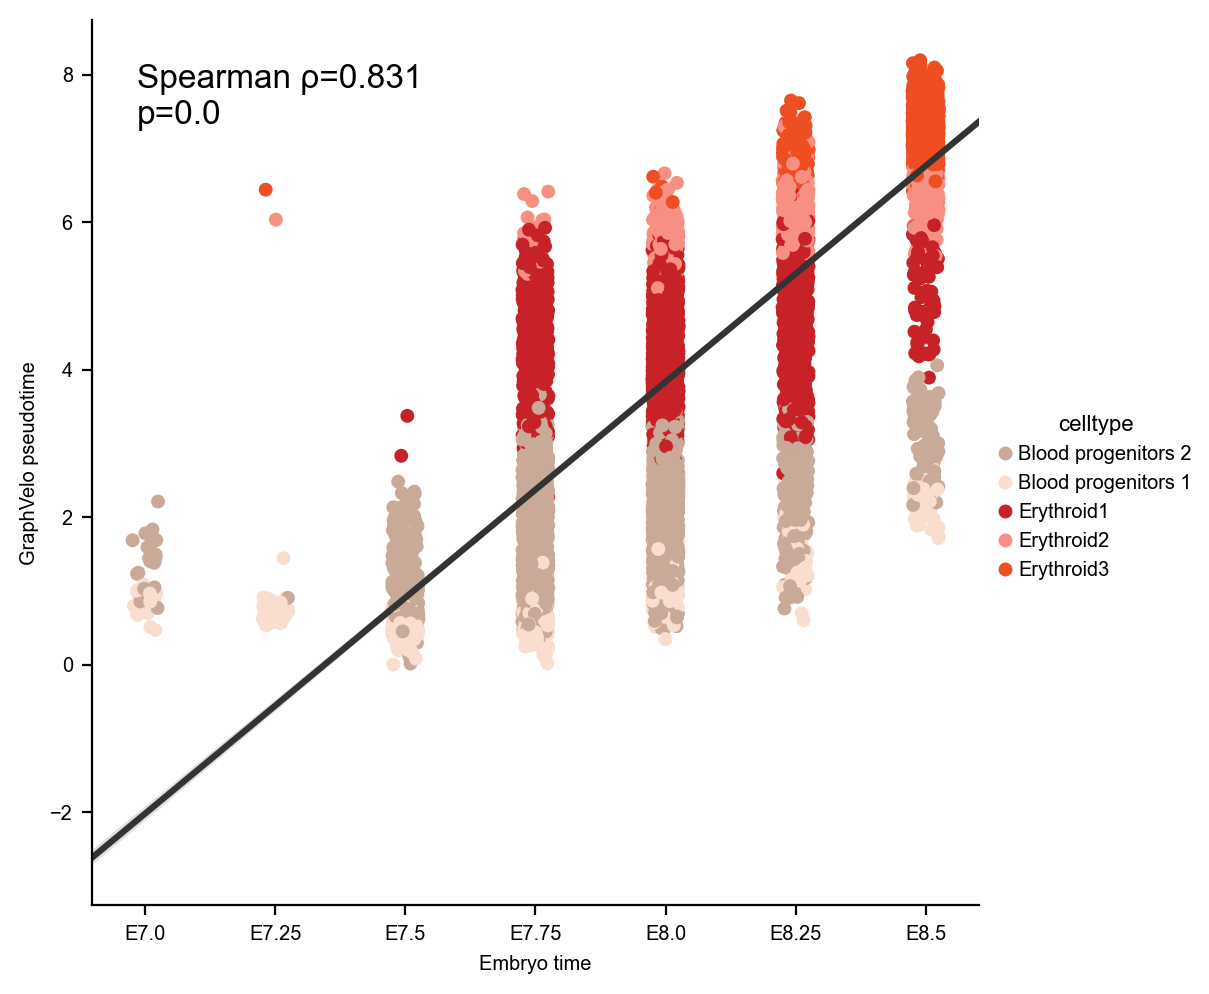

In [9]:
res = spearmanr(df['GraphVelo potential'], df['Embryo time'])
plt.figure(figsize=(5,5))
sns.catplot(
    data=df, x="Embryo time", y="GraphVelo potential", hue="celltype",
    native_scale=True, zorder=1, palette=color_map
)
ax = sns.regplot(
    data=df, x="Embryo time", y="GraphVelo potential",
    scatter=False, truncate=False, order=1, color=".2",
)

ax.text(0.05, 0.95, s=f'Spearman \u03C1={res[0]:.3f}\np={res[1]}', transform=ax.transAxes, fontsize=12, color='black', verticalalignment='top');
ax.set_xticks([7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5])
ax.set_xticklabels(['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5'])
ax.set_ylabel('GraphVelo pseudotime')
# plt.savefig('figures/graphvelo_time.pdf', format='pdf', dpi=300) 
plt.show()

### Vector field-based pseudotime

|-----------> plotting with basis key=X_umap


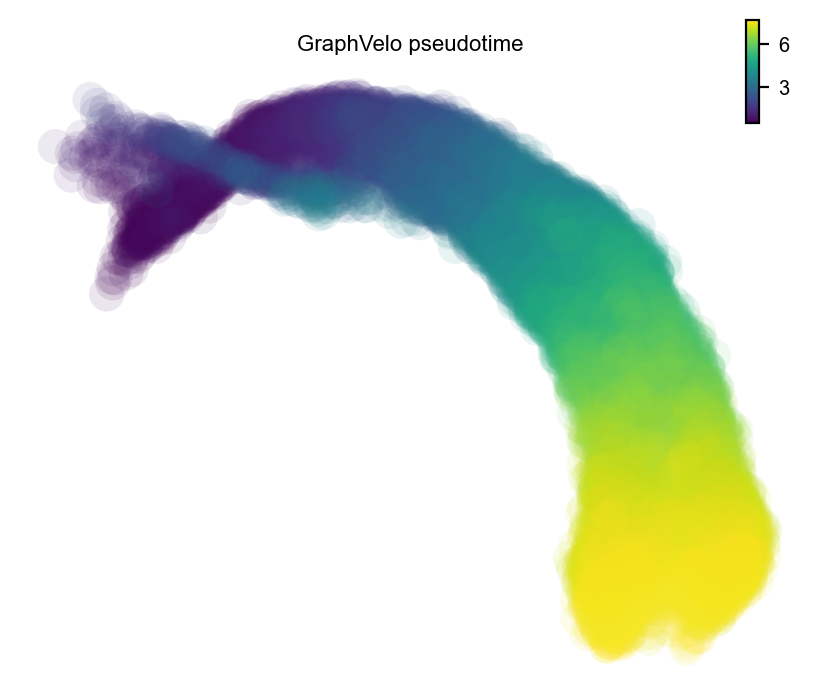

In [10]:
ax = dyn.pl.scatters(adata_dyn, color='pca_ddhodge_potential', figsize=(5,4), save_show_or_return='return')
ax.set_title('GraphVelo pseudotime')
plt.show()

### Calculate gene-wise acceleration as a potential predictor of MURK genes

In [11]:
dyn.vf.speed(adata_dyn, basis='pca')
dyn.vf.divergence(adata_dyn, basis='pca')
dyn.vf.acceleration(adata_dyn, basis='pca')
dyn.vf.curvature(adata_dyn, basis='pca')

Calculating divergence: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.2295s]
|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.2079s]
|-----> [Calculating curvature] in progress: 100.0000%|-----> [Calculating curvature] completed [0.2099s]


|-----> X shape: (9815, 2) V shape: (9815, 2)
|-----------> plotting with basis key=X_umap
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap


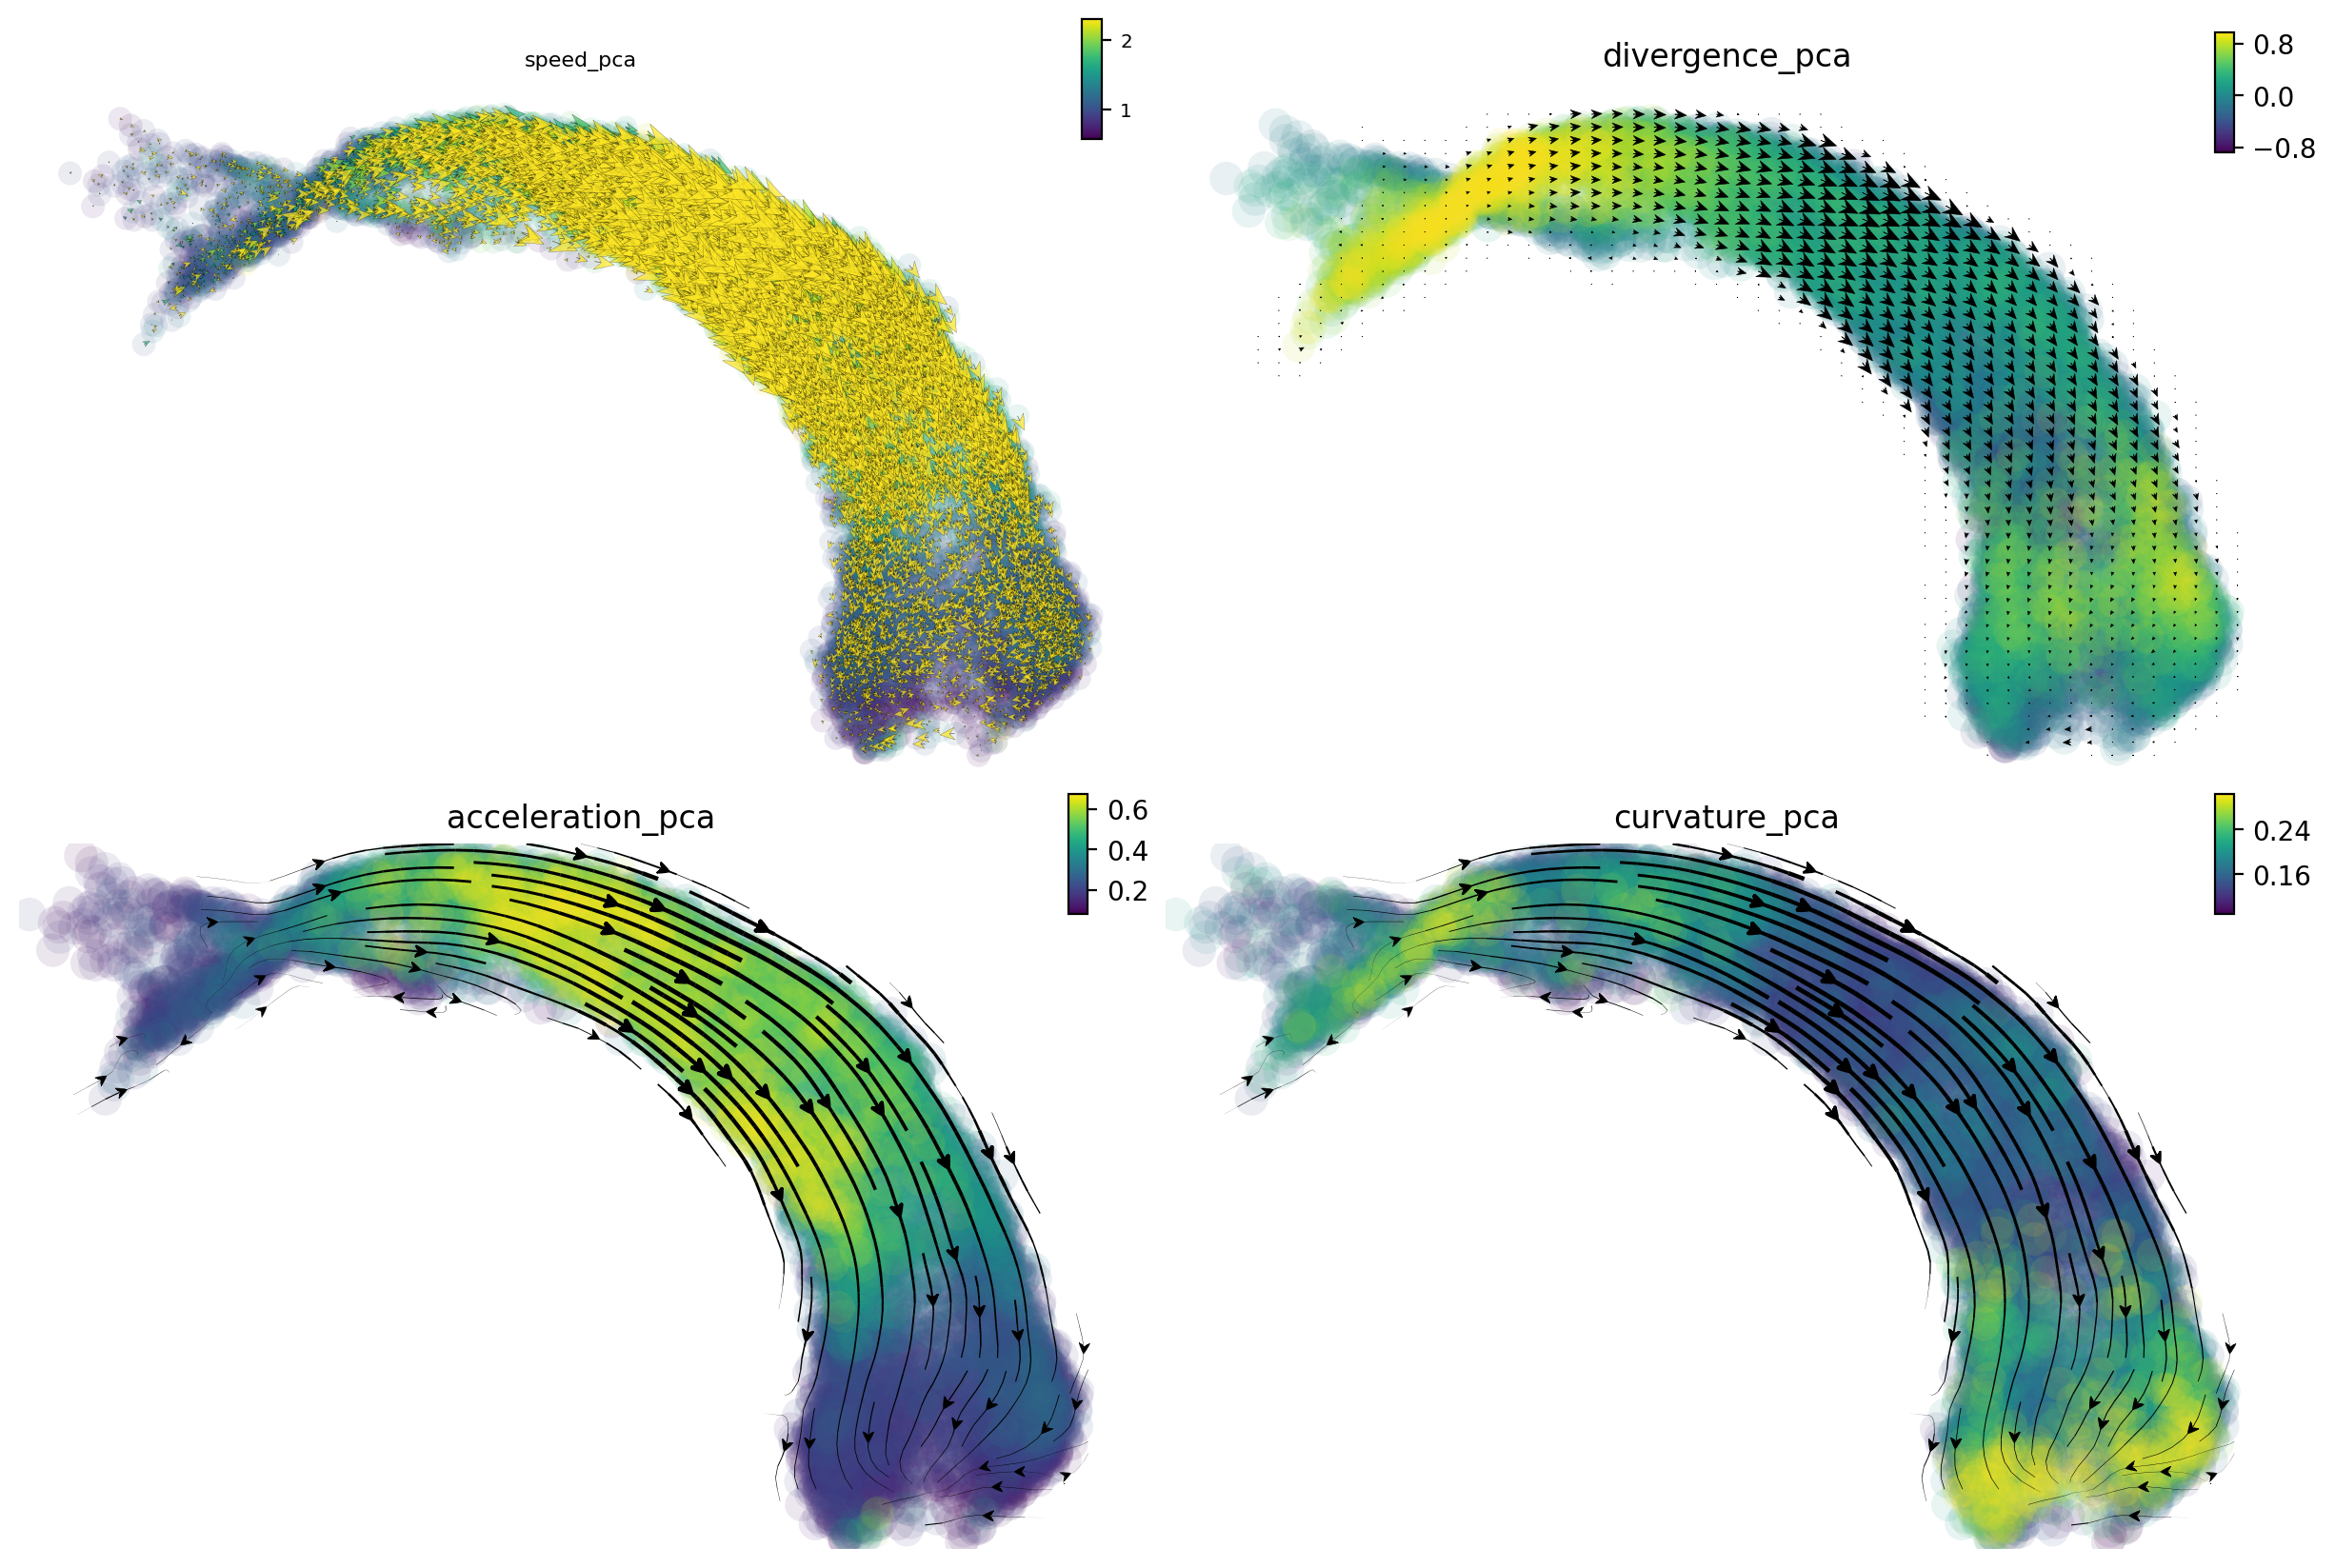

In [12]:
fig1, f1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(12, 8))
f1_axes
f1_axes[0, 0] = dyn.pl.cell_wise_vectors(adata_dyn, color='speed_pca', vector='gv', pointsize=0.5, alpha = 0.7, ax=f1_axes[0, 0], quiver_length=12, quiver_size=6, save_show_or_return='return')
f1_axes[0, 1] = dyn.pl.grid_vectors(adata_dyn, color='divergence_pca', vector='gv', ax=f1_axes[0, 1], quiver_length=60, quiver_size=40, save_show_or_return='return')
f1_axes[1, 0] = dyn.pl.streamline_plot(adata_dyn, color='acceleration_pca', vector='gv', ax=f1_axes[1, 0], save_show_or_return='return')
f1_axes[1, 1] = dyn.pl.streamline_plot(adata_dyn, color='curvature_pca', vector='gv', ax=f1_axes[1, 1], save_show_or_return='return')
plt.show()

In [13]:
dyn.vf.rank_acceleration_genes(adata_dyn)

AnnData object with n_obs × n_vars = 9815 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'pca_ddhodge_sampled', 'pca_ddhodge_div', 'pca_potential', 'pca_ddhodge_potential', 'divergence_pca', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'speed_pca', 'acceleration_pca', 'curvature_pca'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'mack_score', 'use_for_pca'
    uns: 'celltype_colors', 'gv_params', 'log1p', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'dyn

In [14]:
murk_gene = adata_dyn[:, adata_dyn.var['MURK_gene']].var_names

In [15]:
df = adata_dyn.uns['rank_abs_acceleration']
df['rank'] = df.index + 1  # Assign ranks based on index + 1
ranked_genes = {gene: df.loc[df['all'] == gene, 'rank'].iloc[0] for gene in murk_gene}
ranked_genes_df = pd.DataFrame(list(ranked_genes.items()), columns=['Gene', 'Rank'])
ranked_genes_df.head(10)

Gene  Rank
0     Mgst3    15
1      Ppox   590
2     Creg1   111
3  Slc30a10  1301
4     Nudt4   345
5     Fuca2  1516
6   Chchd10    26
7    Arid3a   574
8    Dhrs11   519
9    Slc4a1   123

In [16]:
def rank_predict_helper(df, gene_name, sortby, val_abs, ascending, marker_genes):
    if val_abs:
        sort_df = df.loc[abs(df[sortby]).sort_values(ascending=ascending).index]
    else: 
        sort_df = df.loc[df[sortby].sort_values(ascending=ascending).index]
    is_marker = sort_df[gene_name].isin(marker_genes)
    tpr = []
    fpr = []
    for cutoff in range(1, len(sort_df) + 1):
        tp = np.sum(is_marker[:cutoff])
        fp = cutoff - tp
        tpr.append(tp / len(marker_genes))
        fpr.append(fp / (len(sort_df)-len(marker_genes)))
    return tpr, fpr

In [17]:
df = adata_dyn.uns['rank_abs_acceleration']
df['rank'] = df.index + 1
conf_df = pd.DataFrame(adata_dyn.var['mack_score'])
conf_df.loc[np.isnan(conf_df.values)] = 0
conf_df['names'] = conf_df.index
np.random.seed(0)
rand_df = pd.DataFrame({'names': adata_dyn.var_names, 'scores': np.random.permutation(adata_dyn.n_vars)})
tpr_rand, fpr_rand = rank_predict_helper(rand_df, 'names', 'scores', False, False, murk_gene)
tpr, fpr = rank_predict_helper(adata_dyn.uns['rank_abs_acceleration'], 'all', 'rank', True, True, murk_gene)
tpr_conf, fpr_conf = rank_predict_helper(conf_df, 'names', 'mack_score', False, False, murk_gene)
auroc = np.trapz(tpr, fpr)
auroc_conf = np.trapz(tpr_conf, fpr_conf)
auroc_rand = np.trapz(tpr_rand, fpr_rand)

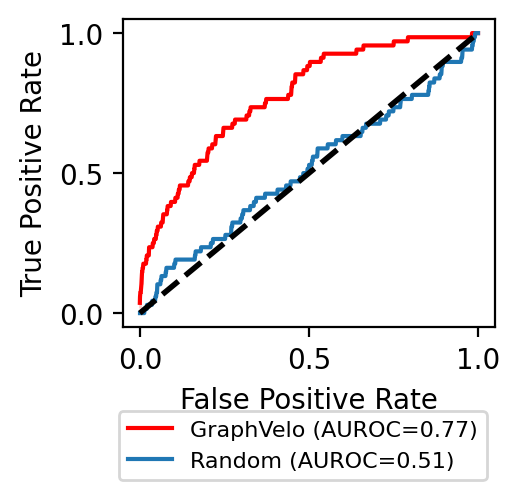

In [18]:
fig, ax = plt.subplots(figsize=(2.4, 2))
sns.lineplot(x=fpr, y=tpr, label=f'GraphVelo (AUROC={auroc:.2f})', c='r')
# sns.lineplot(x=fpr_conf, y=tpr_conf, label=f'Mac score (AUROC={auroc_conf:.2f})')
sns.lineplot(x=fpr_rand, y=tpr_rand, label=f'Random (AUROC={auroc_rand:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.yticks([0, 0.5, 1.0])
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=1, prop={'size': 8}, bbox_transform=fig.transFigure)
# plt.savefig('figures_sup/murk_gene_prediction.pdf', dpi=300, bbox_inches='tight')
plt.show()

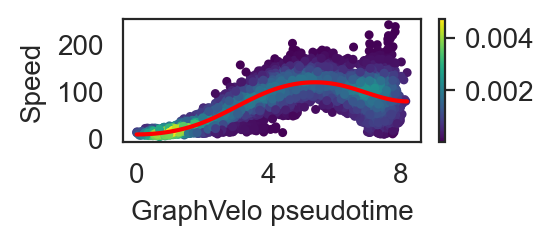

In [19]:
from pygam import LinearGAM, s
from scipy.stats import gaussian_kde
t = adata_dyn.obs['pca_ddhodge_potential']
x = np.linalg.norm(adata_dyn.layers['velocity_gv'], axis=1)
kernel = gaussian_kde(np.vstack((t, x)))(np.vstack((t, x)))
term  =s(
    0,
    spline_order=3,
    n_splines=7
)
gam = LinearGAM(term, max_iter=1000, verbose=False).fit(t, x)
tx = gam.generate_X_grid(term=0)
sns.set_style('white')
fig, ax = plt.subplots(1, 1, figsize=(2.4, 0.8))
ax.plot(tx[:, 0], gam.predict(tx), c='r')
sc = ax.scatter(t, x, c=kernel, cmap="viridis", s=5)
cbar = plt.colorbar(sc, ax=ax)
ax.set_xlabel('GraphVelo pseudotime', fontsize=10)
ax.set_ylabel('Speed', fontsize=10)
plt.xticks([0, 4, 8])
plt.yticks([0, 100, 200])
# plt.savefig('figures_sup/cell_speed_trend.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [20]:
adata_dyn.var['use_for_dynamics'] = True

## Dynamo Jacobian analyses reveals gene regulation mechnisms of TFs

In [21]:
dyn.vf.jacobian(adata_dyn, ['Gata1', 'Gata2', 'Klf1'])

Transforming subset Jacobian: 100%|██████████| 9815/9815 [00:00<00:00, 82671.49it/s]


AnnData object with n_obs × n_vars = 9815 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'pca_ddhodge_sampled', 'pca_ddhodge_div', 'pca_potential', 'pca_ddhodge_potential', 'divergence_pca', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'speed_pca', 'acceleration_pca', 'curvature_pca', 'jacobian_det_pca'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'mack_score', 'use_for_pca', 'use_for_dynamics'
    uns: 'celltype_colors', 'gv_params', 'log1p', 'neighbors', 'pca', 'velocity_graph', 'velo

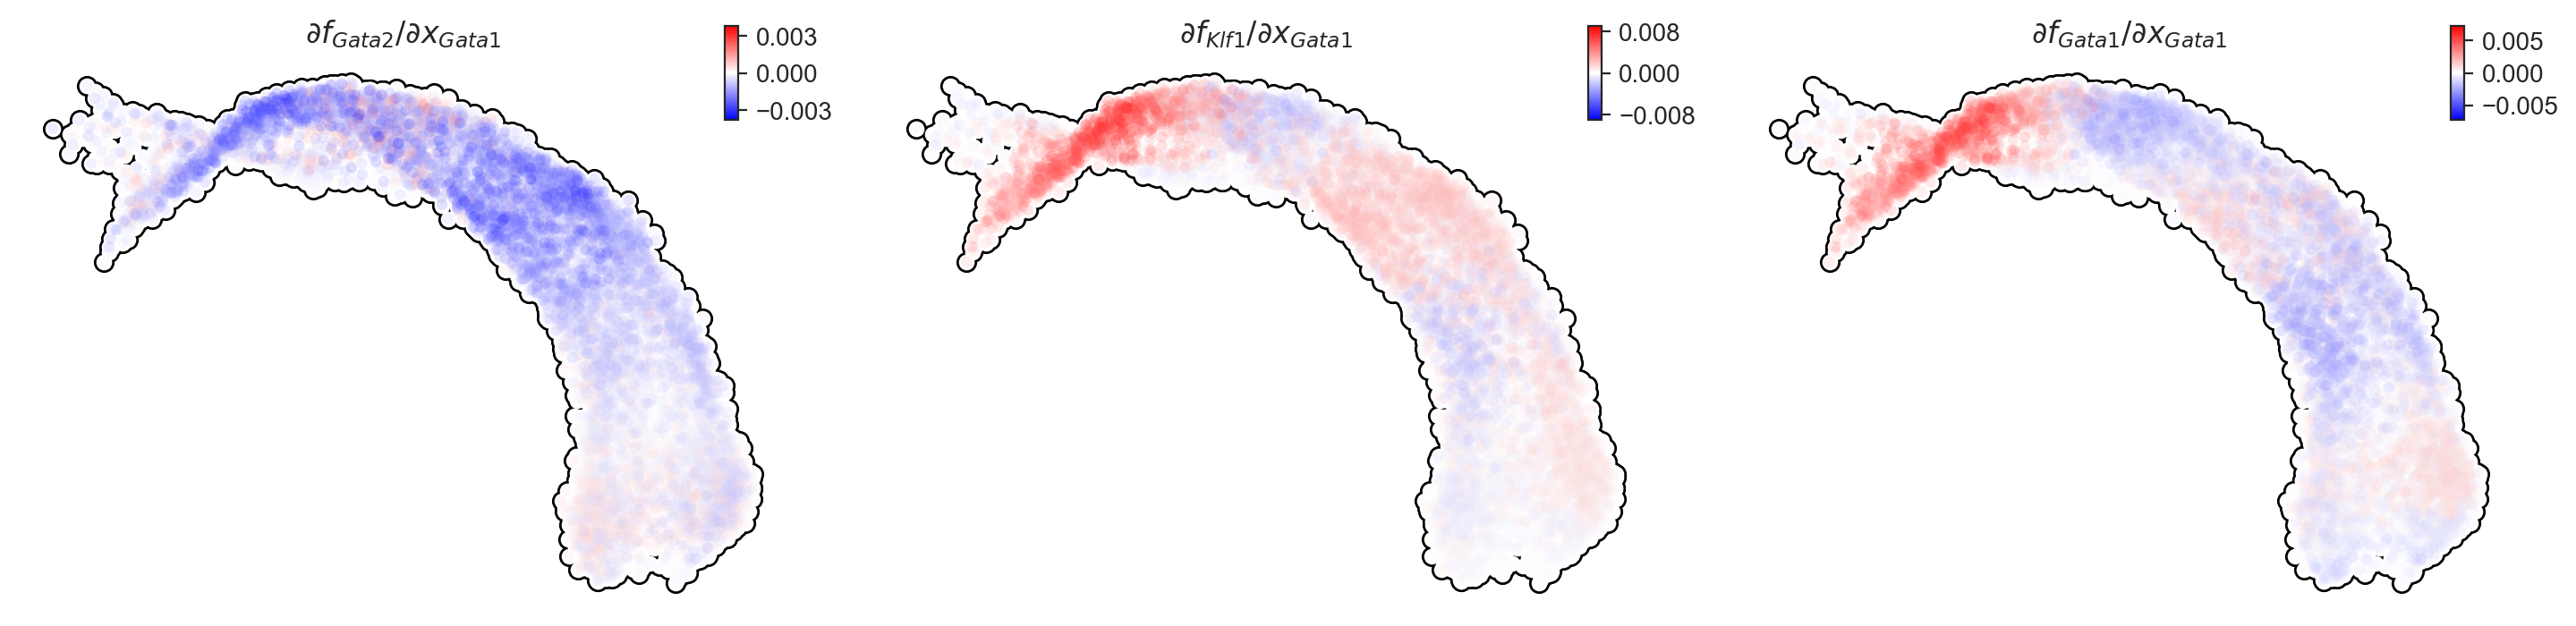

In [22]:
dyn.pl.jacobian(adata_dyn, ['Gata1'], ['Gata2', 'Gata1', 'Klf1'])

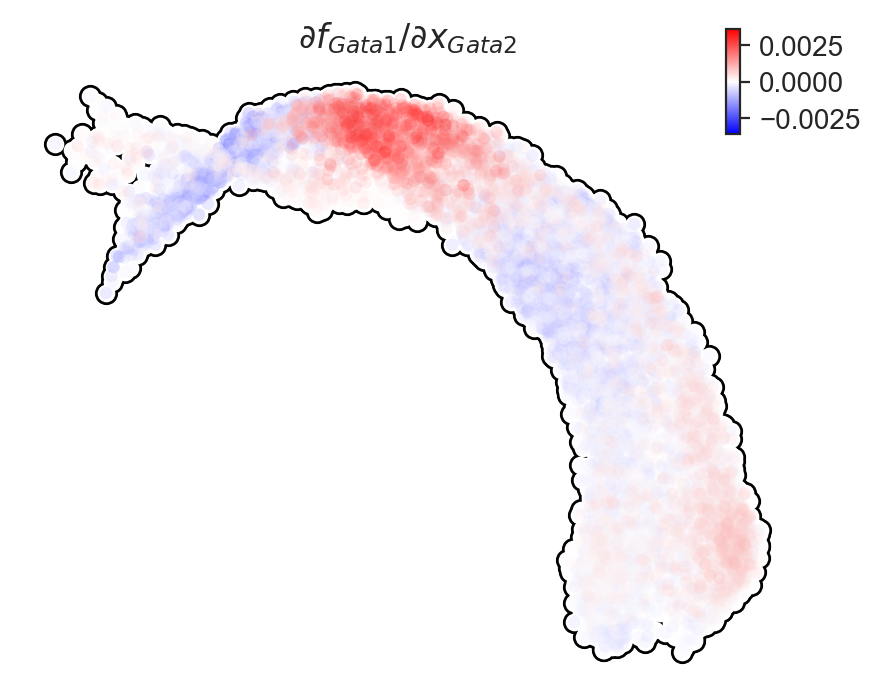

In [23]:
dyn.pl.jacobian(adata_dyn, ['Gata2'], ['Gata1'], sort='raw', figsize=(5,4))

|-----------> plotting with basis key=X_umap


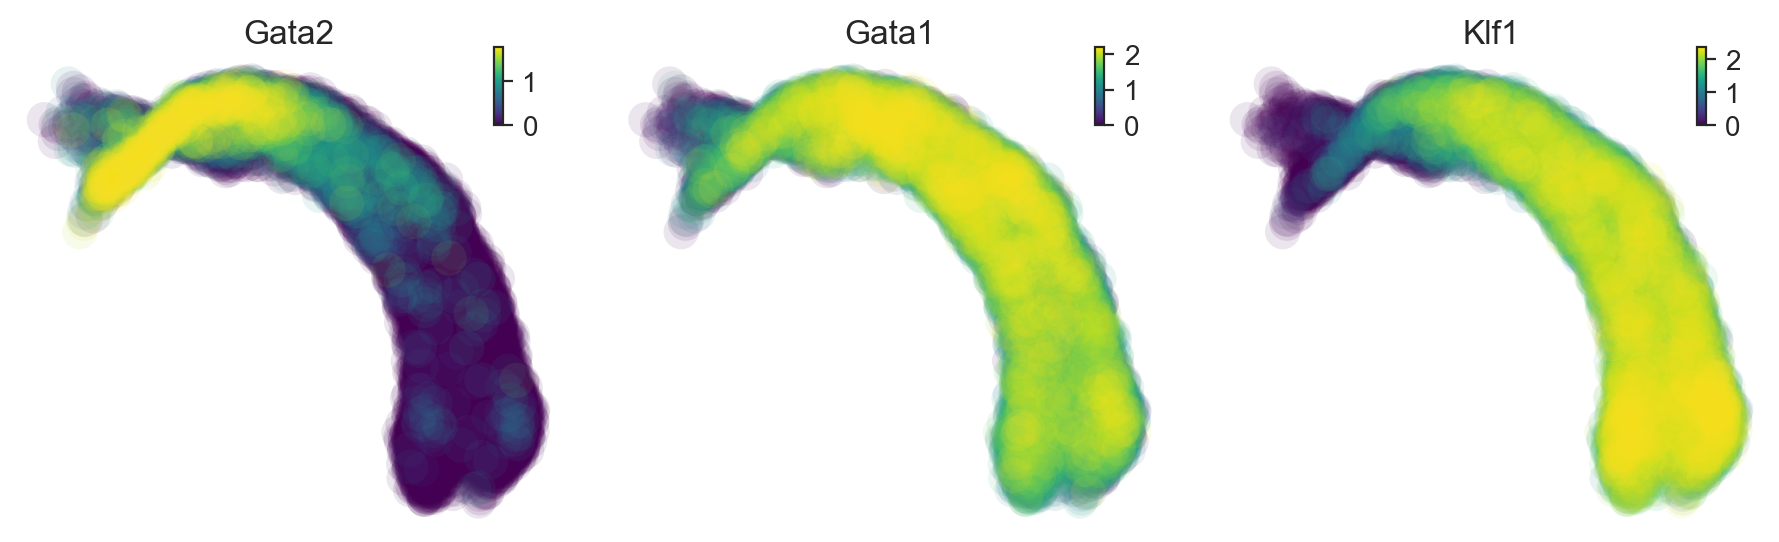

In [24]:
dyn.pl.scatters(adata_dyn, color=['Gata2', 'Gata1', 'Klf1'], figsize=(4,3))

### Visualize gene/velocity trends along vector field-based pseudotime axis

Fitting trends using GAM: 100%|██████████| 3/3 [00:00<00:00, 15.72it/s]


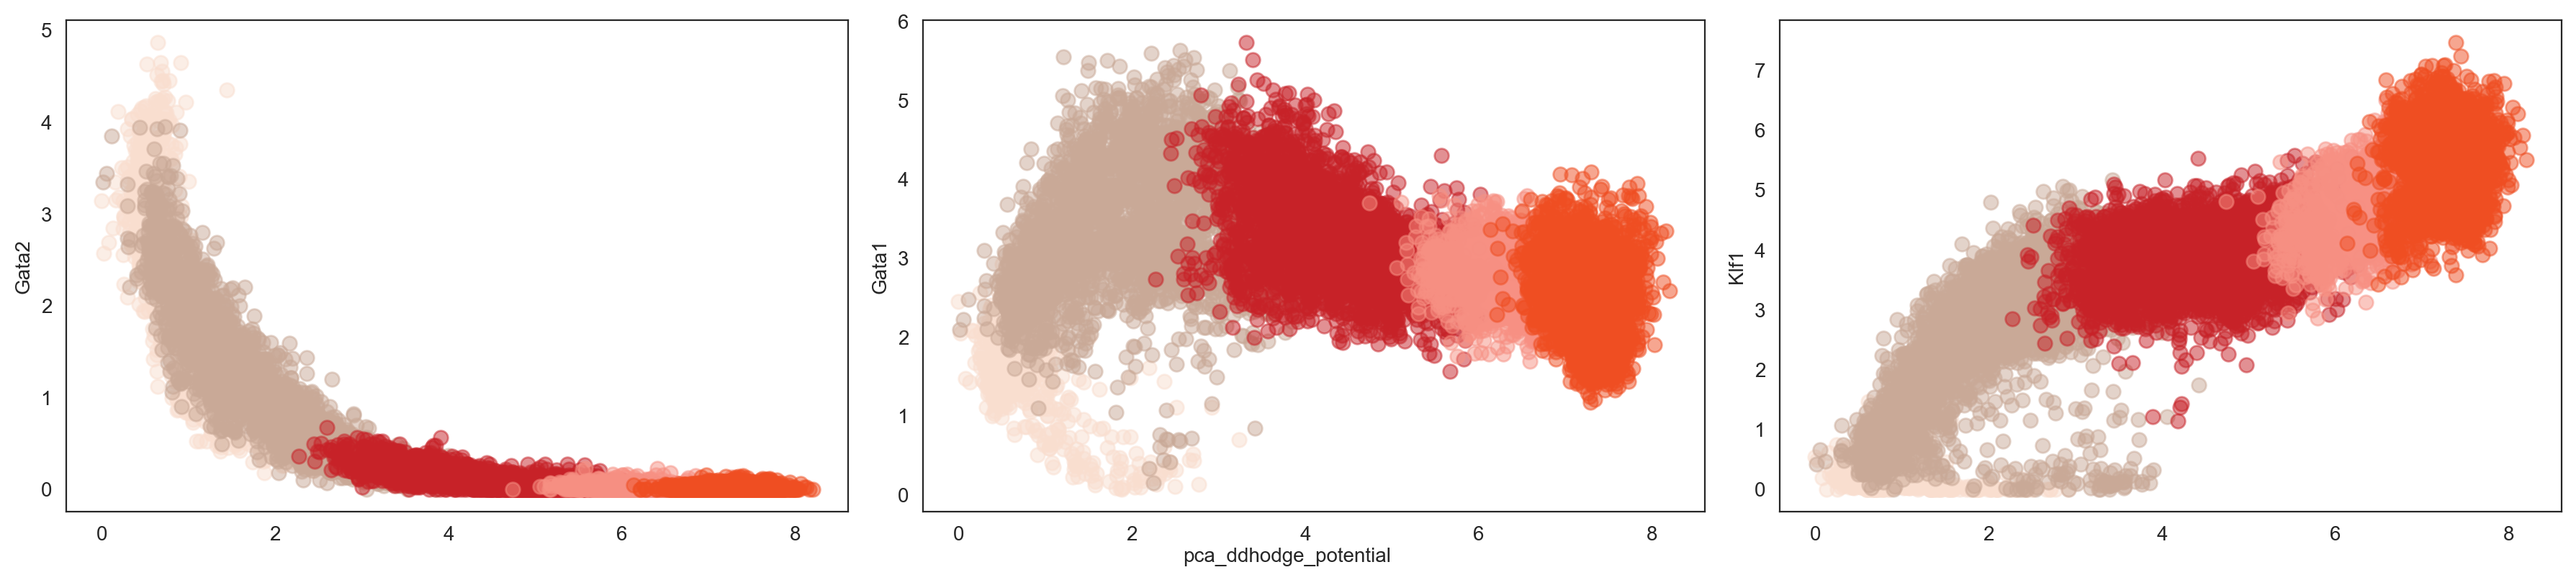

Fitting trends using GAM: 100%|██████████| 3/3 [00:00<00:00, 47.86it/s]


<Figure size 640x480 with 0 Axes>

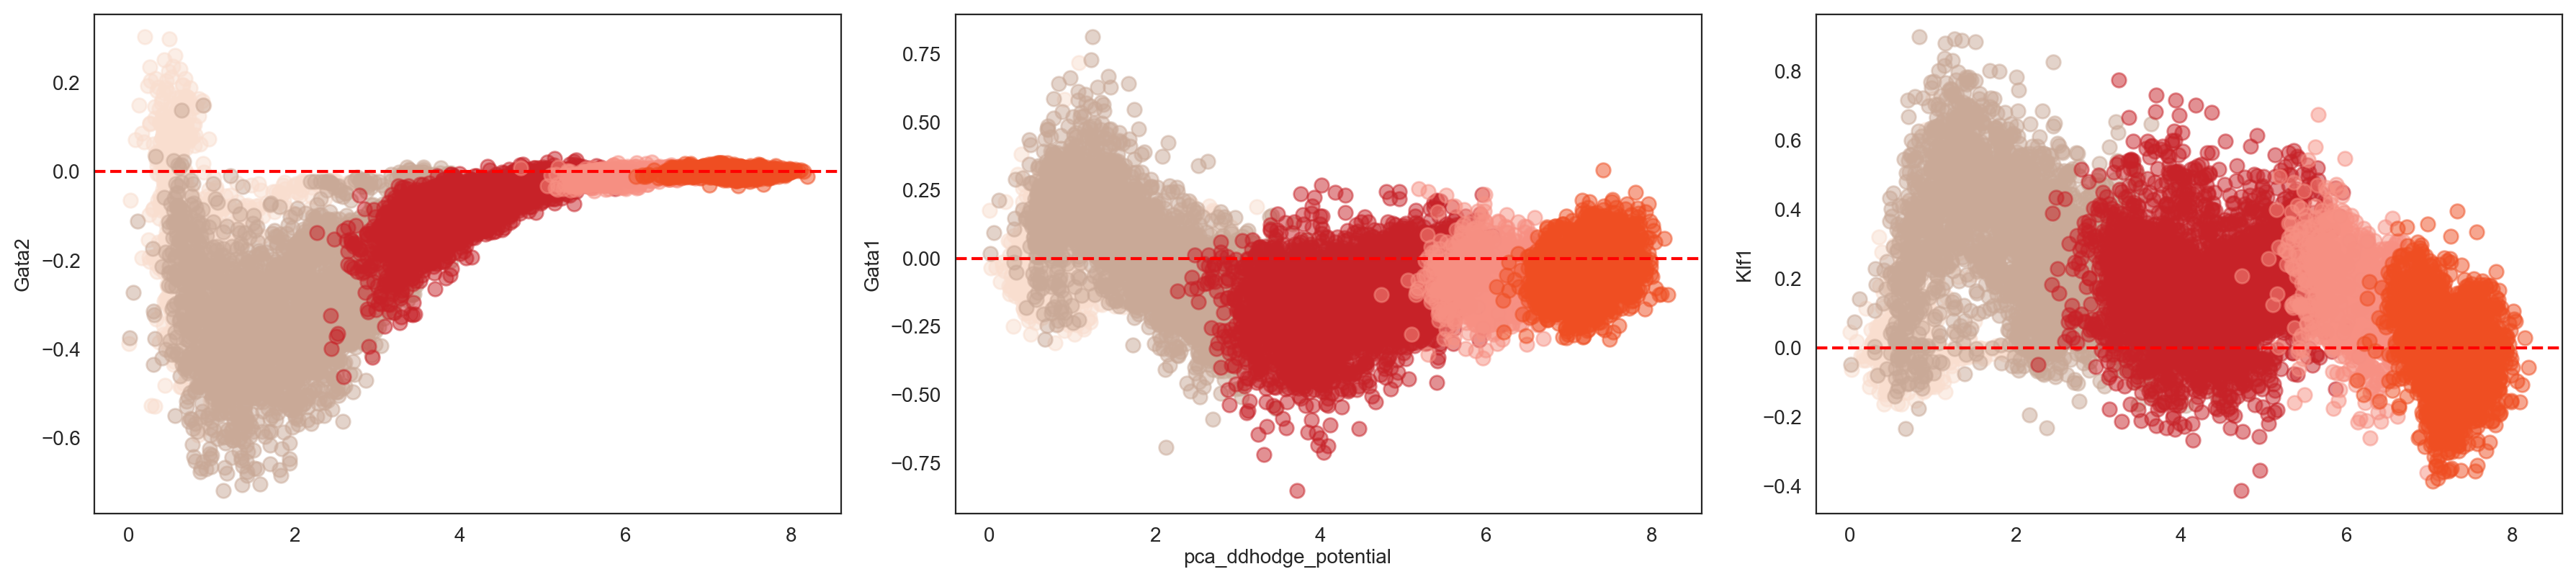

Fitting trends using GAM: 100%|██████████| 3/3 [00:00<00:00, 27.70it/s]


<Figure size 640x480 with 0 Axes>

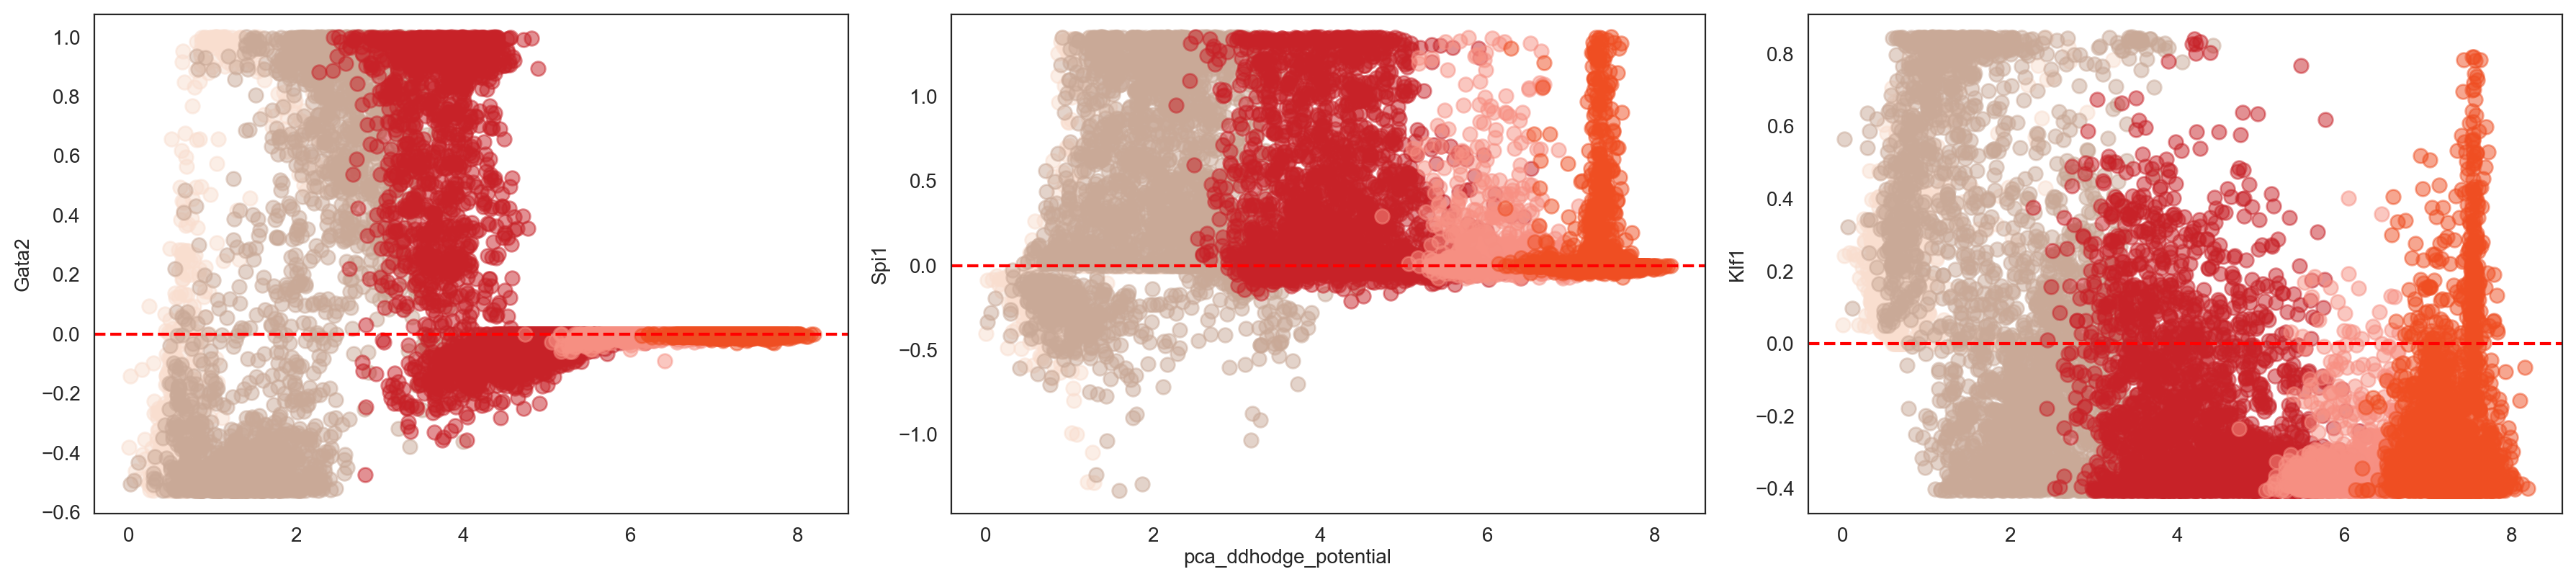

In [25]:
adata_dyn.uns['celltype_colors'] = np.array(['#f9decf', '#c9a997', '#C72228', '#f79083', '#EF4E22'])
adata_dyn.layers['velocity_scv'] = adata.layers['velocity'].copy()
gene_trend(adata_dyn, genes=['Gata2', 'Gata1', 'Klf1'], tkey='pca_ddhodge_potential', pointsize=50, layer='M_s', hide_trend=True, color='celltype',)
plt.show()
plt.clf()
gene_trend(adata_dyn, genes=['Gata2', 'Gata1', 'Klf1'], tkey='pca_ddhodge_potential', pointsize=50, layer='velocity_gv', hide_trend=True, color='celltype', zero_indicator=True)
plt.show()
plt.clf()
gene_trend(adata_dyn, genes=['Gata2', 'Spi1', 'Klf1'], tkey='pca_ddhodge_potential', pointsize=50, layer='velocity_scv', hide_trend=True, color='celltype', zero_indicator=True)
plt.show()
plt.clf()

### In silico perturbation implemented by dynamo

|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....
|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.7321s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap_perturbation
|-----------> skip filtering celltype by stack threshold when stacking color because it is not a numeric type


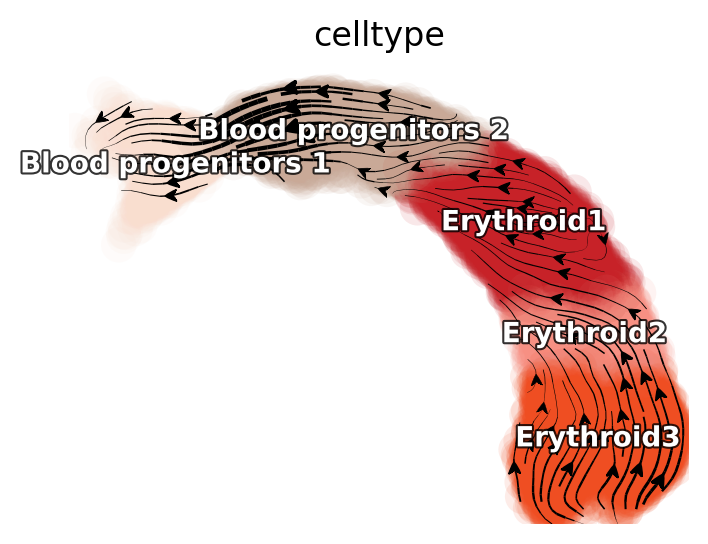

In [30]:
gene = "Gata1"
dyn.pd.perturbation(adata_dyn, gene, [-10], emb_basis="umap")
ax = dyn.pl.streamline_plot(adata_dyn, color=["celltype"], figsize=(4, 3), color_key=color_map, basis="umap_perturbation", save_show_or_return='return')
plt.savefig(str(FIG_DIR) + '/suppl_figures_mouse_ery/gata1_ko.png', dpi=300, transparent=True,  bbox_inches='tight')
plt.show()

|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....
|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.7404s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap_perturbation
|-----------> skip filtering celltype by stack threshold when stacking color because it is not a numeric type


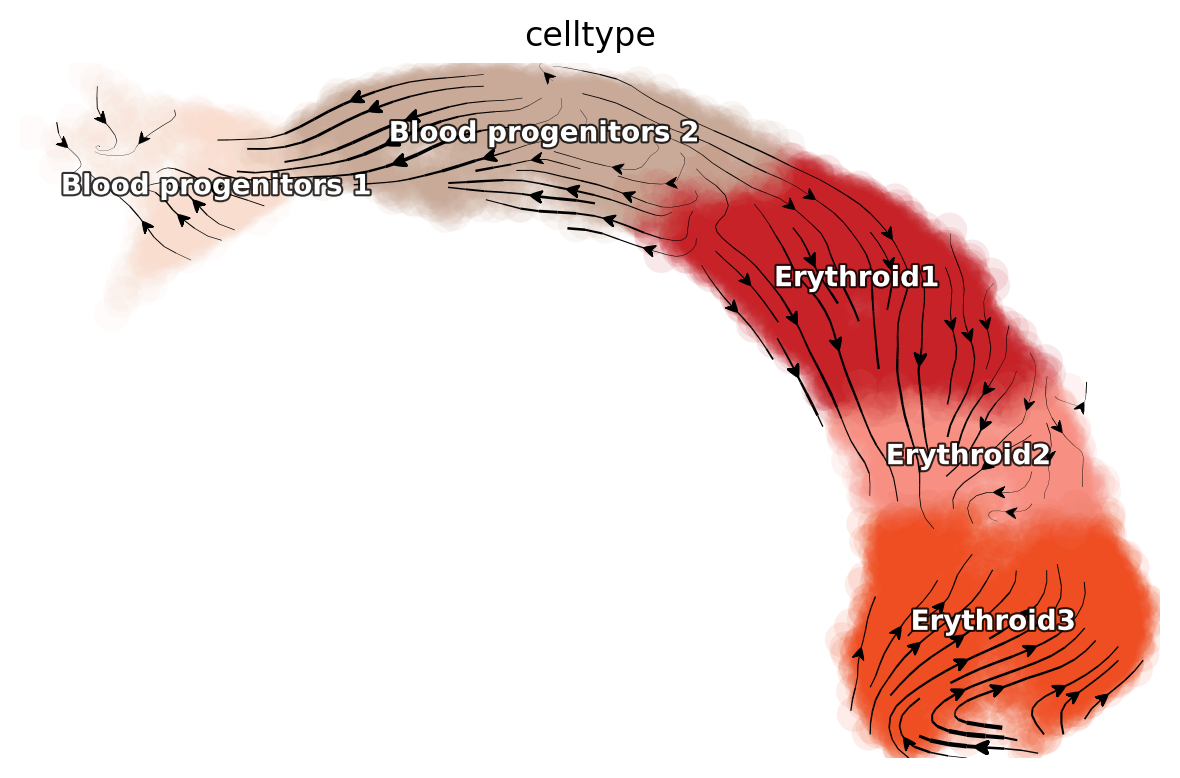

In [31]:
gene = "Spi1"
dyn.pd.perturbation(adata_dyn, gene, [10], emb_basis="umap")
dyn.pl.streamline_plot(adata_dyn, color=["celltype"], color_key=color_map, basis="umap_perturbation")